In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
base_image_path = 'http://guereak.com/nst/base_image_1.jpg'
style_reference_image_path_1 = 'http://guereak.com/nst/style_transfer_1.jpg'
style_reference_image_path_2 = 'http://guereak.com/nst/style_transfer_2.jpg'
style_reference_image_path_3 = 'http://guereak.com/nst/style_transfer_3.jpg'
style_reference_image_path_4 = 'http://guereak.com/nst/style_transfer_4.jpg'

style_reference_image_path = style_reference_image_path_3

1) Download and load the images

In [4]:
base_image_path = keras.utils.get_file(origin=base_image_path)
style_reference_image_path = keras.utils.get_file(origin=style_reference_image_path)

2128819/2128819 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Set image dimensions
original_width, original_height = keras.utils.load_img(base_image_path).size
# img_height = 400  # Fixed height
# img_width = round(original_width * img_height / original_height)  # Maintain aspect ratio
img_height = 128
img_width = 128

In [6]:
def preprocess_image(image_path):
    """Loads and preprocesses an image with center cropping and RGB normalization."""
    img = Image.open(image_path).convert("RGB")
    width, height = img.size

    # Center crop to square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    img = img.crop((left, top, right, bottom))

    # Resize to target size
    img = img.resize((img_width, img_height))

    # Convert to array and normalize to [0, 1]
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def deprocess_image(img):
    """Converts a normalized image (0–1 range) back to displayable uint8 RGB format."""
    img = img.reshape((img_height, img_width, 3))
    img = np.clip(img * 255.0, 0, 255).astype("uint8")
    return img

We check the original image:

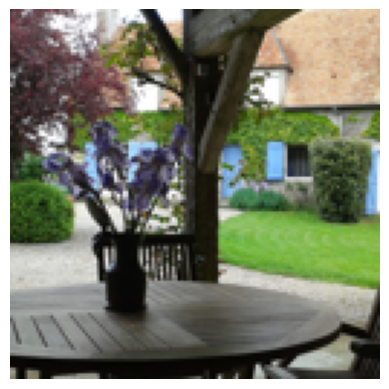

In [7]:
plt.imshow(preprocess_image(base_image_path).reshape((128, 128, 3)))
plt.axis('off')
plt.show()

### Try with our OWN (small) CNN: based on ResNet-18.



In [8]:
!pip -q install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from datasets import load_dataset
import numpy as np

# Ensure GPU is detected
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load CIFAR10 Dataset from Hugging Face
dataset = load_dataset("bitmind/caltech-256")

train_test_split = dataset["train"].train_test_split(test_size=0.2)
dataset["train"] = train_test_split["train"]
dataset["validation"] = train_test_split["test"]

# Get class names
num_classes = 256


Num GPUs Available: 1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/451 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/349M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/262M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/302M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30607 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'filename'],
        num_rows: 24485
    })
    validation: Dataset({
        features: ['image', 'filename'],
        num_rows: 6122
    })
})

In [10]:
# Preprocess images
def preprocess_data(example):
    """Preprocess a Caltech-256 dataset example: resize, normalize, and extract label."""
    # Resize and normalize image
    image = example["image"].resize((128, 128)).convert("RGB")
    image = np.array(image) / 255.0  # Normalize to [0, 1]

    # Extract label string from filename path (e.g., '138.mattress/138_0117.jpg')
    label_folder = example["filename"].split("/")[0]  # '138.mattress'
    label = int(label_folder.split(".")[0])           # '138'

    return {"image": image, "label": label}

# Create tf.data pipeline
def prepare_dataset(split, batch_size=128, shuffle=True):
    ds = dataset[split].map(preprocess_data)
    ds = ds.to_tf_dataset(
        columns=["image"], label_cols=["label"], batch_size=batch_size, shuffle=shuffle
    )
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
    return ds

# Create train & validation datasets
batch_size = 128
train_dataset = prepare_dataset("train", batch_size=batch_size)
val_dataset = prepare_dataset("validation", batch_size=batch_size, shuffle=False)

def FastTinyCNN(input_shape=(128, 128, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

# Load Model
model = FastTinyCNN(num_classes=num_classes)
model.summary()

# Compile Model
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
model.fit(
    train_dataset,
    epochs=3,  # Adjust based on available time
    validation_data=val_dataset,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Save Final Model
model.save("fast_tiny_cnn_caltech_256.h5")

Map:   0%|          | 0/24485 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Map:   0%|          | 0/6122 [00:00<?, ? examples/s]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 128, 128, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,475 (173.73 KB)

 Trainable params: 44,475 (173.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.0242 - loss: 5.3283 

192/192 ━━━━━━━━━━━━━━━━━━━━ 3504s 18s/step - accuracy: 0.0242 - loss: 5.3281 - val_accuracy: 0.0327 - val_loss: 5.2086 - learning_rate: 0.0010
Epoch 2/3
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.0363 - loss: 5.1508 

192/192 ━━━━━━━━━━━━━━━━━━━━ 3492s 18s/step - accuracy: 0.0363 - loss: 5.1505 - val_accuracy: 0.0528 - val_loss: 5.0347 - learning_rate: 0.0010
Epoch 3/3
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.0585 - loss: 4.9530 

192/192 ━━━━━━━━━━━━━━━━━━━━ 3479s 18s/step - accuracy: 0.0585 - loss: 4.9529 - val_accuracy: 0.0640 - val_loss: 4.9661 - learning_rate: 0.0010


In [14]:
model.save("fast_tiny_cnn_caltech_256.keras")

For quick access: Load model from file

In [10]:
model = tf.keras.models.load_model("fast_tiny_cnn_caltech_256.keras")

# Print model summary to verify
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 128, 128, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 64, 64, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 32, 32, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,952 (347.47 KB)

 Trainable params: 44,475 (173.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,477 (173.74 KB)

### Using pretrained VGG19

In [ ]:
# Load pre-trained VGG19 model (without fully connected layers)
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

In [11]:
outputs_dict = {layer.name: layer.output for layer in model.layers}
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

No clue what these do:

In [12]:
def content_loss(base_img, combination_img):
    """Computes content loss (difference between base and generated image)."""
    return tf.reduce_sum(tf.square(combination_img - base_img))

def gram_matrix(x):
    """Computes Gram matrix for style representation."""
    x = tf.transpose(x, (2, 0, 1))  # Rearrange dimensions
    features = tf.reshape(x, (tf.shape(x)[0], -1))  # Flatten
    return tf.matmul(features, tf.transpose(features))

def style_loss(style_img, combination_img):
    """Computes style loss using Gram matrices."""
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    """Computes total variation loss for smoothness."""
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [29]:
# WORKS ONLY FOR TinyCNN. Do VGG instead

# Define layers for style and content extraction
style_layer_names = [
    "separable_conv2d_1", "separable_conv2d_2"
]
content_layer_name = "separable_conv2d"

# Define weights for the losses
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [25]:
def compute_loss(combination_image, base_image, style_reference_image):
    """Computes the total loss combining content, style, and variation losses."""
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    # Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    # Style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        loss += (style_weight / len(style_layer_names)) * style_loss(style_reference_features, combination_features)

    # Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    """Computes gradients for the optimization step."""
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Load an optimizer: try various approaches

In [26]:
# TODO try other optimizers
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

## Time to run our code!

In [27]:
# Load and preprocess images
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(0.5 * preprocess_image(base_image_path) +
                                 0.5 * preprocess_image(style_reference_image_path))

In [30]:
# Run optimization loop
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=0.00
Iteration 200: loss=0.00
Iteration 300: loss=0.00
Iteration 400: loss=0.00
Iteration 500: loss=0.00
Iteration 600: loss=0.00
Iteration 700: loss=0.00
Iteration 800: loss=0.00
Iteration 900: loss=0.00
Iteration 1000: loss=0.00
Iteration 1100: loss=0.00
Iteration 1200: loss=0.00
Iteration 1300: loss=0.00
Iteration 1400: loss=0.00
Iteration 1500: loss=0.00
Iteration 1600: loss=0.00
Iteration 1700: loss=0.00
Iteration 1800: loss=0.00
Iteration 1900: loss=0.00
Iteration 2000: loss=0.00
Iteration 2100: loss=0.00
Iteration 2200: loss=0.00
Iteration 2300: loss=0.00
Iteration 2400: loss=0.00
Iteration 2500: loss=0.00
Iteration 2600: loss=0.00
Iteration 2700: loss=0.00
Iteration 2800: loss=0.00
Iteration 2900: loss=0.00
Iteration 3000: loss=0.00
Iteration 3100: loss=0.00
Iteration 3200: loss=0.00
Iteration 3300: loss=0.00
Iteration 3400: loss=0.00
Iteration 3500: loss=0.00
Iteration 3600: loss=0.00
Iteration 3700: loss=0.00
Iteration 3800: loss=0.00
Iteration 3900: loss=

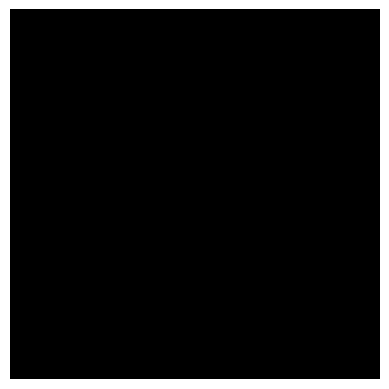

In [23]:
# Display final output
final_img_path = "combination_image_at_iteration_4000.png"
plt.imshow(keras.utils.load_img(final_img_path))
plt.axis('off')
plt.show()